In [ ]:
import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def solve_duffing(d, a, b, gamma, w, x):
    """Solves the Duffing equation with the gamma * cos(w*t) term using odeint.
    d: Damping coefficient
    a: Linear stiffness coefficient
    b: Nonlinear stiffness coefficient
    gamma: Amplitude of the cosine term
    w: Angular frequency
    x: Time array
    """
    def duffing(y, t):
        y0, y1 = y
        dydt = [y1, -d * y1 - a * y0 - b * y0**3 + gamma * np.cos(w * t)]
        return dydt

    y0 = [0, 0]  # Initial conditions for y and y'
    sol = odeint(duffing, y0, x)
    
    # Convert the solution to a torch tensor and return
    y = torch.tensor(sol[:, 0])
    return y



class FCN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers):
        super(FCN, self).__init__()
        self.fcs = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        for _ in range(num_hidden_layers - 1):
            self.fcs.append(nn.Linear(hidden_size, hidden_size))
        self.fco = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fcs[0](x)  # Use the first linear layer for x_physics
        for layer in self.fcs[1:]:
            x = layer(x)
        x = self.fco(x)
        return x

In [ ]:
# Example usage with modified parameters for increased oscillations:
d = 0.001  # Damping coefficient (reduced for more oscillations)
a = 1.0  # Linear stiffness coefficient
b = -1.0  # Nonlinear stiffness coefficient
gamma = 0.5
w = 20
x = torch.linspace(0, 10, 1000).view(-1) 
y = solve_duffing(d, a, gamma,b,w, x).view(-1,1)
print(x.shape, y.shape)

# Slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)
x_data = x.view(-1,1)
y_data = y

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [ ]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain

torch.manual_seed(123)
# Define the neural network model
model = FCN(1, 1, 32, 3)
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Sample location on the domain for physics loss
#x = torch.linspace(0, 10, 1000).view(-1, 1).requires_grad_(True)

# Set the time variable for the physics loss
#t = x.view(-1)


# Create a list to store generated files (for GIF creation)
files = []

for i in range(6000):
    optimizer.zero_grad()

    # Compute the "data loss" using the Duffing equation
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data)** 2)  # Use mean squared error

    # Compute the physics loss using the custom autograd function
    yhp = model(x_physics)
    dy_pred = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), retain_graph=True)[0]
    dy_pred = dy_pred.requires_grad_(True)
    d2y_pred = torch.autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True)[0]

# Continue with the rest o
    # Define the physics loss equation based on the Duffing equation
    physics = d2y_pred + d * dy_pred + a * yhp + b * torch.pow(yhp, 3) - gamma * torch.cos(w * x_physics)

    # Specify what you want to do with the physics loss
    loss_physics = (1e-4)*torch.mean(physics ** 2)

    # Combine the data loss and physics loss
    total_loss = loss1 + loss_physics

    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()
  
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)

torch.Size([1000]) torch.Size([1000, 1])
torch.Size([10]) torch.Size([10, 1])


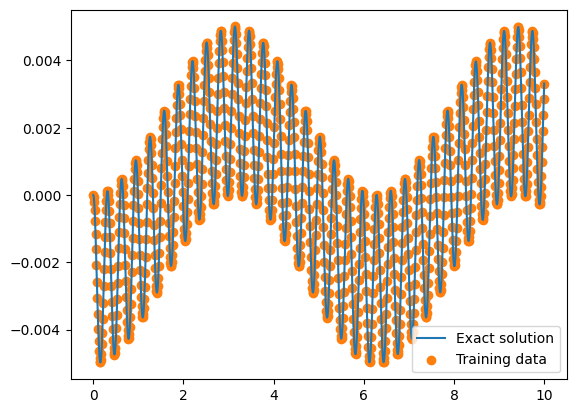

d2y_pred is None. Checking computation graph...
yhp.requires_grad: True
dy_pred.requires_grad: True
x_physics.requires_grad: True
x_physics.grad_fn: None


RuntimeError: d2y_pred is None. Check the computation graph.

In [14]:
import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def solve_duffing(d, a, b, gamma, w, x):
    """Solves the Duffing equation with the gamma * cos(w*t) term using odeint.
    d: Damping coefficient
    a: Linear stiffness coefficient
    b: Nonlinear stiffness coefficient
    gamma: Amplitude of the cosine term
    w: Angular frequency
    x: Time array
    """
    def duffing(y, t):
        y0, y1 = y
        dydt = [y1, -d * y1 - a * y0 - b * y0**3 + gamma * np.cos(w * t)]
        return dydt

    y0 = [0, 0]  # Initial conditions for y and y'
    sol = odeint(duffing, y0, x)
    
    # Convert the solution to a torch tensor and return
    y = torch.tensor(sol[:, 0])
    return y

class FCN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers):
        super(FCN, self).__init__()
        self.fcs = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        for _ in range(num_hidden_layers - 1):
            self.fcs.append(nn.Linear(hidden_size, hidden_size))
        self.fco = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fcs[0](x)  # Use the first linear layer for x_physics
        for layer in self.fcs[1:]:
            x = layer(x)
        x = self.fco(x)
        return x

# Example usage with modified parameters for increased oscillations:
d = 0.001  # Damping coefficient (reduced for more oscillations)
a = 1.0  # Linear stiffness coefficient
b = -1.0  # Nonlinear stiffness coefficient
gamma = 0.5
w = 20
x = torch.linspace(0, 10, 1000).view(-1) 
y = solve_duffing(d, a, gamma, b, w, x).view(-1,1)
print(x.shape, y.shape)

# Slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)
x_data = x.view(-1,1)
y_data = y

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True) # sample locations over the problem domain
 # sample locations over the problem domain

torch.manual_seed(123)
# Define the neural network model
model = FCN(1, 1, 32, 3)
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Create a list to store generated files (for GIF creation)
files = []

for i in range(6000):
    optimizer.zero_grad()

    # Compute the "data loss" using the Duffing equation
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data)**2)  # Use mean squared error


    yhp = model(x_physics)
    dy_pred = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    dy_pred = dy_pred.requires_grad_(True)

    # Check if d2y_pred is None and add debug information
    d2y_pred = torch.autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True, allow_unused=True)[0]

    # Debug information
    if d2y_pred is None:
        print("d2y_pred is None. Checking computation graph...")
        print("yhp.requires_grad:", yhp.requires_grad)
        print("dy_pred.requires_grad:", dy_pred.requires_grad)
        print("x_physics.requires_grad:", x_physics.requires_grad)
        print("x_physics.grad_fn:", x_physics.grad_fn)
        raise RuntimeError("d2y_pred is None. Check the computation graph.")

# Define the physics loss equation based on the Duffing equation
    physics = d2y_pred + d * dy_pred + a * yhp + b * torch.pow(yhp, 3) - gamma * torch.cos(w * x_physics)


    # Specify what you want to do with the physics loss
    loss_physics = (1e-4) * torch.mean(physics** 2)

    # Combine the data loss and physics loss
    total_loss = loss1 + loss_physics

    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()
  
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)
